# Training Parameterized Quantum Circuits

In this section we will have a closer look at how to train circuit-based models using gradient based methods, what restrictions these models have and how we might overcome them.

## Contents

1. [Introduction](#Introduction)
1. [Gradients](#Gradients)
1. [Limitations](#Limitations)
1. [References](#References)

## Introduction



Like classical models, we can train parameterized quantum circuit models to perform data-driven tasks. The task of learning an arbitrary function from data is mathematically expressed as the minimization of a cost or loss function $f(\vec\theta)$, also known as the
objective function, with respect to the parameter vector $\vec\theta$. Generally, when training a parameterized quantum circuit model, the function we are trying to minimise is the expectation value: $\langle \Psi(\vec\theta) | \hat{H}| \Psi(\vec\theta) \rangle$
<figure>
  <img src="images/training.png" style="width:400px">
</figure> 

There are two different types of algorithms that we can use to optimise the parameters of a variational circuit, $\mathbf{U_\theta}$: gradient-based and gradient-free methods, we will be discussing gradient-based methods. 

## Gradients

If we have a function $f(\vec\theta)$, and we have access to the gradient of the function, $\nabla f(\vec\theta)$, starting from an initial point, then the simplest way to minimize the function is to update the parameters towards the direction of steepest descent of the function: $\vec\theta_{n+1} = \vec\theta_n - \eta\nabla f(\vec\theta)$, where $\eta$ is the learning rate - a small, positive hyperparameter controlling the size of the update. We continue doing this until we converge to a local minimum of the function, $f(\vec\theta^*)$.

<figure>
  <img src="images/gradientdescent.png" style="width:400px">
</figure>

This technique is called **gradient descent** or **vanilla gradient descent**, since it's the plain gradient, we aren't doing anything special to it. 

Qiskit provides different methods to compute gradients of expectation values, let's explore them!

First we need to define our parameterized state, $|\Psi(\vec\theta)\rangle = U(\vec\theta)|0\rangle$ where $U(\vec\theta)$ is given by the Qiskit [`RealAmplitudes`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html) circuit on two qubits:

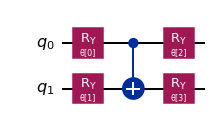

In [1]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=2, reps=1, entanglement='linear').decompose()
ansatz.draw('mpl', style='iqx')

Next we need to define a Hamiltonian, let's use: $\hat H = \hat Z \bigotimes \hat Z$

In [2]:
from qiskit.opflow import Z, I

hamiltonian = Z ^ Z

Putting them together to make the expectation value: $\langle \Psi(\vec\theta) | \hat{H}| \Psi(\vec\theta) \rangle$

In [3]:
from qiskit.opflow import StateFn, PauliExpectation

expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(ansatz)
pauli_basis = PauliExpectation().convert(expectation)

Next we write a function to simulate the measurement of the expectation value:

In [4]:
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliExpectation, CircuitSampler

quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'), shots = 8192, seed_simulator = 2718, seed_transpiler = 2718)
sampler = CircuitSampler(quantum_instance)

def evaluate_expectation(x):
    value_dict = dict(zip(ansatz.parameters, x))
    result = sampler.convert(pauli_basis, params=value_dict).eval()  
    return np.real(result)

To make things concrete, let's fix a point $\vec p$ and an index $i$ and ask: What's the derivative of the expectation value with respect to parameter $\theta_i$ at point $\vec p$?

$$
    \frac{\partial}{\partial \theta_i} \langle \Psi(\vec\theta) | \hat H | \Psi(\vec\theta) \rangle \bigg\vert_{\vec\theta = \vec p}
$$

We'll choose a random point $\vec p$ and index $i=2$ (remember we start counting from 0).

In [5]:
import numpy as np

point = np.random.random(ansatz.num_parameters)
index = 2

### Finite difference gradients

Arguably the simplest way to approximate gradients is with a finite difference scheme. This works independently of the function's inner, possibly very complex, structure.

<figure>
  <img src="images/finitedifference.png" style="width:400px">
</figure>

If we are interested in estimating the gradient at $f(\theta)$, we can choose some small distance $\epsilon$ and calculate $f(\theta+\epsilon)$ and $f(\theta-\epsilon)$ and take the difference between the two function values, divided by the distance: $\nabla f(\theta) \approx \frac{1}{2\epsilon}\left(f(\theta+\epsilon) - f(\theta-\epsilon) \right)$.

In [6]:
eps = 0.2
e_i = np.identity(point.size)[:, index]  # identity vector with a 1 at index ``index``, otherwise 0

plus = point + eps * e_i
minus = point - eps * e_i

In [7]:
finite_difference = (evaluate_expectation(plus) - evaluate_expectation(minus)) / (2 * eps)
print(finite_difference)

0.18981933593750014


Instead of doing this manually, we can use Qiskit's [`Gradient`](https://qiskit.org/documentation/stubs/qiskit.aqua.operators.gradients.Gradient.html) class for this.

In [8]:
from qiskit.opflow import Gradient

shifter = Gradient('fin_diff', analytic=False, epsilon=eps)
grad = shifter.convert(expectation, params=ansatz.parameters[index])
print(grad)

SummedOp([
  2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐     ┌────────────────┐
    q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2] + 0.2) ├
         ├──────────┤┌─┴─┐└──┬──────────┬──┘
    q_1: ┤ Ry(θ[1]) ├┤ X ├───┤ Ry(θ[3]) ├───
         └──────────┘└───┘   └──────────┘   
    )
  ]),
  -2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐     ┌────────────────┐
    q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2] - 0.2) ├
         ├──────────┤┌─┴─┐└──┬──────────┬──┘
    q_1: ┤ Ry(θ[1]) ├┤ X ├───┤ Ry(θ[3]) ├───
         └──────────┘└───┘   └──────────┘   
    )
  ])
])


In [9]:
value_dict = dict(zip(ansatz.parameters, point))
sampler.convert(grad, value_dict).eval().real

0.1617431640625001

Finite difference gradients can be volatile on noisy functions and using the exact formula for the gradient can be more stable.

<figure>
  <img src="images/noisygradient.png" style="width:400px">
</figure>



### Analytic gradients

Analytics gradients try to evaluate the analytic formula for the gradients. In general, that is fairly difficult, because we have have to do a manual calculation, but for circuit based gradients, there's a very nice theoretical result that gives us a very easy formula for calculating gradients - the _parameter shift_ rule first introduced in Reference [1](#References).

For a simple circuit consisting of only Pauli rotations, without any coefficients, then this rule says that the analytic gradient is:
<figure>
  <img src="images/parametershift.png" style="width:400px">
</figure>
which is very similar to the equation for finite difference gradients. 

Let's try calculate it by hand:

In [10]:
eps = np.pi / 2
e_i = np.identity(point.size)[:, index]

plus = point + eps * e_i
minus = point - eps * e_i

finite_difference = (evaluate_expectation(plus) - evaluate_expectation(minus)) / 2

print(finite_difference)

0.20227050781250006


And using the Qiskit [`Gradient`](https://qiskit.org/documentation/stubs/qiskit.aqua.operators.gradients.Gradient.html) class:

In [11]:
shifter = Gradient()  # parameter-shift rule is the default
grad = shifter.convert(expectation, params=ansatz.parameters[index])
sampler.convert(grad, value_dict).eval().real

0.2020263671875

We see that the calculated analytic gradient is fairly similar to the calculated finite difference gradient. 

Now that we know to calculate gradients, let's try optimizing the expectation value!

First we fix an initial point for reproducibility.

In [12]:
# initial_point = np.random.random(ansatz.num_parameters)
initial_point = np.array([0.43253681, 0.09507794, 0.42805949, 0.34210341])

Similar to how we had a function to evaluate the expectation value, we'll need a function to evaluate the gradient.

In [13]:
gradient = Gradient().convert(expectation)
gradient_in_pauli_basis = PauliExpectation().convert(gradient)
sampler = CircuitSampler(quantum_instance)

def evaluate_gradient(x):
    value_dict = dict(zip(ansatz.parameters, x))
    result = sampler.convert(gradient_in_pauli_basis, params=value_dict).eval()
    return np.real(result)    

To compare the convergence of the optimizers, we can keep track of the loss at each step by using a callback function.

<figure>
  <img src="images/callback.png" style="width:400px">
</figure>

In [14]:
from qiskit.algorithms.optimizers import GradientDescent

gd_loss = []
def gd_callback(nfevs, x, fx, stepsize):
    gd_loss.append(fx)
    
gd = GradientDescent(maxiter=300, learning_rate=0.01, callback=gd_callback)

And now we start the optimization and plot the loss!

In [15]:
x_opt, fx_opt, nfevs = gd.optimize(initial_point.size,    # number of parameters
                                   evaluate_expectation,  # function to minimize
                                   gradient_function=evaluate_gradient,  # function to evaluate the gradient
                                   initial_point=initial_point)  # initial point

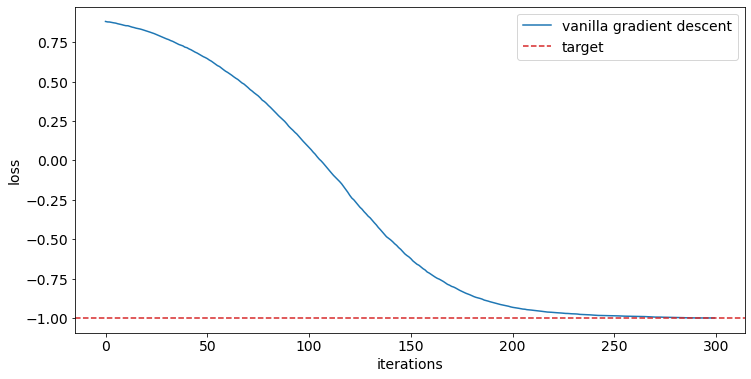

In [16]:
import matplotlib 
import matplotlib.pyplot as plt
matplotlib.rcParams['font.size'] = 14

plt.figure(figsize=(12, 6))
plt.plot(gd_loss, label='vanilla gradient descent')
plt.axhline(-1, ls='--', c='tab:red', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend();

### Natural gradients

We see in the above example that we are able to find the minimum of the function using gradient descent. However this is not always the case.

<figure>
  <img src="images/gradientfail.png" style="width:600px">
</figure>

For example, if we look at the diagram on the left, given the initial point on the edge of the loss landscape, $\theta_0 = (x_0,y_0)$ and learning rate $\eta$, we are able to approach the minimum in the centre. However, looking at the diagram on the right, where the loss landscape has been squashed in the $x$-dimension, we see that using the same initial point and learning rate, we are unable to find the minimum, as we are not taking into account that the loss landscape might vary at a different rate with respect to each parameter.  

The idea of natural gradients is to change the we determine $\theta_{n+1}$ from $\theta_n$. In vanilla gradients, we used the Euclidean distance between them: $\eta = d = |\vec\theta_{n+1}-\vec\theta_n|$, but we saw that this doesn't take the loss landscape into account. Instead in natural gradients, we use a distance that is dependent on our model: $d = \left|\langle \Psi(\vec\theta_n)|\Psi(\vec\theta_{n+1}) \rangle\right|^2$.

<figure>
  <img src="images/distances.png" style="width:800px">
</figure>

<figure>
  <img src="images/qfi.png" style="width:600px">
</figure>

This metric is called the **Quantum Fisher Information**, $g_{ij}(\vec\theta)$, and allows us to transform the steepest descent in the Euclidean parameter space to the steepest descent in the model space, in what is called **Quantum Natural Gradient**, introduced in Reference [2](#References), where $\vec\theta_{n+1} = \vec\theta_n-\eta g^{-1}(\vec\theta_n)\vec\nabla f(\theta_n)$.

<figure>
  <img src="images/naturalgradients.png" style="width:800px">
</figure>

To evaluate the natural gradient in Qiskit, it is very simple, we just use the [`NaturalGradient`](https://qiskit.org/documentation/stubs/qiskit.aqua.operators.gradients.NaturalGradient.html) instead of the [`Gradient`](https://qiskit.org/documentation/stubs/qiskit.aqua.operators.gradients.Gradient.html)!

In [17]:
from qiskit.opflow import NaturalGradient

Analogous to the function to compute gradients, we can now write a function to evaluate the natural gradients.

In [18]:
natural_gradient = NaturalGradient(regularization='ridge').convert(expectation)
natural_gradient_in_pauli_basis = PauliExpectation().convert(natural_gradient)
sampler = CircuitSampler(quantum_instance, caching="all")

def evaluate_natural_gradient(x):
    value_dict = dict(zip(ansatz.parameters, x))
    result = sampler.convert(natural_gradient, params=value_dict).eval()  
    return np.real(result)    

And as you can see they do indeed differ!

In [19]:
print('Vanilla gradient:', evaluate_gradient(initial_point))
print('Natural gradient:', evaluate_natural_gradient(initial_point))

Vanilla gradient: [ 0.13989258 -0.35095215 -0.25402832 -0.22497559]
Natural gradient: [ 0.7158704  -0.86457346 -0.98086467 -0.33820315]


Let's look at how this influences the convergence.

In [20]:
qng_loss = []
def qng_callback(nfevs, x, fx, stepsize):
    qng_loss.append(fx)
    
qng = GradientDescent(maxiter=300, learning_rate=0.01, callback=qng_callback)

In [21]:
x_opt, fx_opt, nfevs = qng.optimize(initial_point.size, 
                                    evaluate_expectation, 
                                    gradient_function=evaluate_natural_gradient,
                                    initial_point=initial_point)

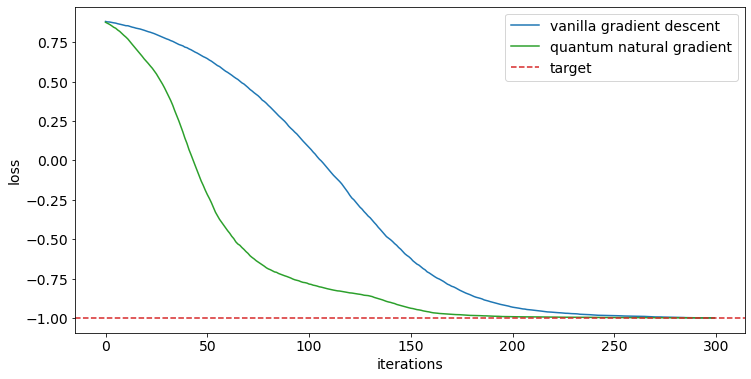

In [22]:
def plot_loss():
    plt.figure(figsize=(12, 6))
    plt.plot(gd_loss, 'tab:blue', label='vanilla gradient descent')
    plt.plot(qng_loss, 'tab:green', label='quantum natural gradient')
    plt.axhline(-1, c='tab:red', ls='--', label='target')
    plt.ylabel('loss')
    plt.xlabel('iterations')
    plt.legend()
    
plot_loss()

This looks great! We can see that the quantum natural gradient approaches the target faster than vanilla gradient descent. However, this comes at the cost of needing to evaluate many many more quantum circuits.

<figure>
  <img src="images/gradientcostsnospsa.png" style="width:600px">
</figure>

### Simultaneous Perturbation Stochastic Approximation

Looking at our function $f(\vec\theta)$ as a vector, if we want to evaluate the gradient $\vec\nabla f(\vec\theta)$, we need to calculate the partial derivation of $f(\vec\theta)$ with respect to each parameter, meaning we would need $2N$ function evaluations for $N$ parameters to calculate the gradient.

<figure>
  <img src="images/spsa.png" style="width:800px">
</figure>

Simultaneous Perturbation Stochastic Approximation or SPSA is an optimization technique where we randomly sample from the gradient, to reduce the number of evaluations. Since we don't care about the exact values but only about convergence, an unbiased sampling should on average work equally well.

In practise, while the exact gradient follows a smooth path to the minimum, SPSA will jump around due to the random sampling, but it will converge, given the same boundary conditions as the gradient. 

And how does it perform? We use the [`SPSA`](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.SPSA.html) algorithm in Qiskit. 

In [23]:
from qiskit.algorithms.optimizers import SPSA

spsa_loss = []
def spsa_callback(nfev, x, fx, stepsize, accepted):
    spsa_loss.append(fx)

spsa = SPSA(maxiter=300, learning_rate=0.01, perturbation=0.01, callback=spsa_callback)

x_opt, fx_opt, nfevs = spsa.optimize(initial_point.size, 
                                     evaluate_expectation, 
                                     initial_point=initial_point)

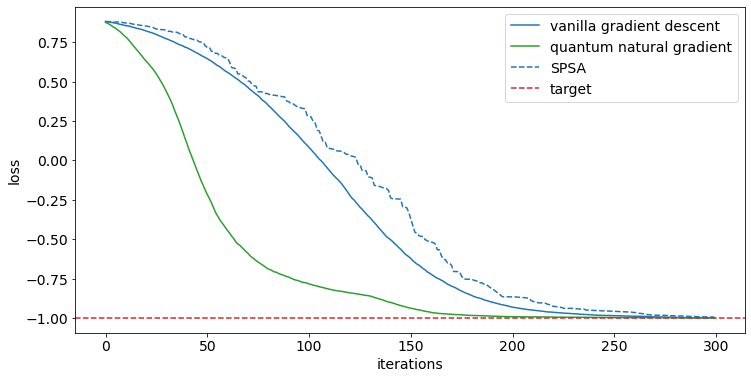

In [24]:
def plot_loss():
    plt.figure(figsize=(12, 6))
    plt.plot(gd_loss, 'tab:blue', label='vanilla gradient descent')
    plt.plot(qng_loss, 'tab:green', label='quantum natural gradient')
    plt.plot(spsa_loss, 'tab:blue', ls='--', label='SPSA')
    plt.axhline(-1, c='tab:red', ls='--', label='target')
    plt.ylabel('loss')
    plt.xlabel('iterations')
    plt.legend()
    
plot_loss()

We can see that SPSA basically follows the gradient descent curve, _and_ at a fraction of the cost!

We can do the same for natural gradients as well, as described in Reference [3](#References). We'll skip the details here, but the idea is to sample not only from the gradient but to extend this to the quantum Fisher information and thus to the natural gradient.

Qiskit implements this as the [`QNSPSA`](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.QNSPSA.html) algorithm. Let's compare its performance:

In [25]:
from qiskit.algorithms.optimizers import QNSPSA

qnspsa_loss = []
def qnspsa_callback(nfev, x, fx, stepsize, accepted):
    qnspsa_loss.append(fx)

fidelity = QNSPSA.get_fidelity(ansatz, quantum_instance, expectation=PauliExpectation())
qnspsa = QNSPSA(fidelity, maxiter=300, learning_rate=0.01, perturbation=0.01, callback=qnspsa_callback)

x_opt, fx_opt, nfevs = qnspsa.optimize(initial_point.size, 
                                       evaluate_expectation, 
                                       initial_point=initial_point)

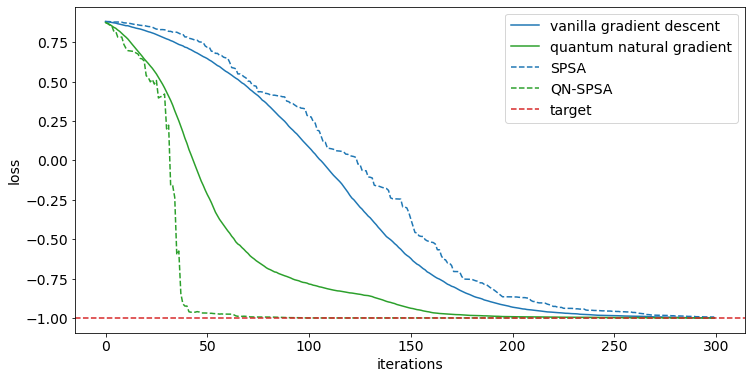

In [26]:
def plot_loss():
    plt.figure(figsize=(12, 6))
    plt.plot(gd_loss, 'tab:blue', label='vanilla gradient descent')
    plt.plot(qng_loss, 'tab:green', label='quantum natural gradient')
    plt.plot(spsa_loss, 'tab:blue', ls='--', label='SPSA')
    plt.plot(qnspsa_loss, 'tab:green', ls='--', label='QN-SPSA')
    plt.axhline(-1, c='tab:red', ls='--', label='target')
    plt.ylabel('loss')
    plt.xlabel('iterations')
    plt.legend()
    
plot_loss()

We can see that QNSPSA somewhat follows the natural gradient descent curve. 

<figure>
  <img src="images/gradientcosts.png" style="width:600px">
</figure>

If we compare the costs, we can see that the vanilla and natural gradients are linear and quadratic in terms of the number of parameters, while the costs for SPSA and QNSPSA are constant, they are independent of the number of parameters. There is the small offset between the costs for SPSA and QNSPSA as more evaluations are required to approximate the natural gradient. 

<div class="alert alert-block alert-info">

**add ``matching`` widget**

match the circuit parameter training method with its description

- Gradient
- Natural Gradient
- SPSA
- QNSPSA


- update the circuit parameters using the gradient of the loss function
- update the circuit parameters using the quantum natural gradient of the loss function
- update the circuit parameters using the approximate gradient of the loss function, calculated using ramdom sampling
- update the circuit parameters using the approximate quantum natural gradient of the loss function, calculated using ramdom sampling

</div>

### Training in practise

In this era of quantum computing, circuit evualations are really expensive and we have noisy readout anyways. Therefore in practice, people often resort to using SPSA. To improve convergence, we do however not use a constant learning rate, but an exponentially decreasing one (solid lines). The typical convergence between a constant learning rate (dotted lines) versus an exponentially decreasing one (solid lines) are shown below. We see that the convergence for a constant learning rate is smooth decreasing line, while the convergence for an exponentially decreasing one is steeper and more staggered. This works well is you know what your loss function looks like. 

<figure>
  <img src="images/learningrate.png" style="width:600px">
</figure>

Qiskit will try to automatically calibrate the learning rate to the model if you don't specify the learning rate.

In [27]:
autospsa_loss = []
def autospsa_callback(nfev, x, fx, stepsize, accepted):
    autospsa_loss.append(fx)

autospsa = SPSA(maxiter=300, learning_rate=None, perturbation=None, callback=autospsa_callback)

x_opt, fx_opt, nfevs = autospsa.optimize(initial_point.size, 
                                         evaluate_expectation, 
                                         initial_point=initial_point)

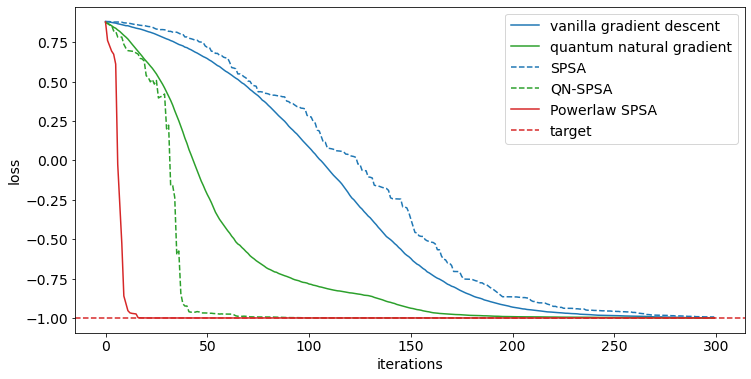

In [28]:
def plot_loss():
    plt.figure(figsize=(12, 6))
    plt.plot(gd_loss, 'tab:blue', label='vanilla gradient descent')
    plt.plot(qng_loss, 'tab:green', label='quantum natural gradient')
    plt.plot(spsa_loss, 'tab:blue', ls='--', label='SPSA')
    plt.plot(qnspsa_loss, 'tab:green', ls='--', label='QN-SPSA')
    plt.plot(autospsa_loss, 'tab:red', label='Powerlaw SPSA')
    plt.axhline(-1, c='tab:red', ls='--', label='target')
    plt.ylabel('loss')
    plt.xlabel('iterations')
    plt.legend()
    
plot_loss()

We see here that it works the best of all the methods for this small model. For larger models, the convergence will probably be more like the natural gradient. 

## Limitations

We've seen that training with gradients works well on the small example model. But can we expect the same if we increase the number of qubits? To investigate that, we measure the variance of the gradients for different model sizes. The idea is simple: if the variance is really small, we don't have enough information to update our parameters.

### Exponentially vanishing gradients (barren plateaus)

Let's pick a standard parameterized quantum circuit ([`RealAmplitudes`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html)) and see what happens if we increase the number of qubits and layers, that is increase the width and depth of thee circuit) as we calculate the gradient.

<figure>
  <img src="images/bpcircuit.png" style="width:400px">
</figure>

In [29]:
from qiskit.opflow import I

def sample_gradients(num_qubits, reps, local=False):
    """Sample the gradient of our model for ``num_qubits`` qubits and ``reps`` repetitions.
    
    We sample 100 times for random parameters and compute the gradient of the first RY rotation gate.
    """
    index = num_qubits - 1

    # local or global operator
    if local:
        operator = Z ^ Z ^ (I ^ (num_qubits - 2))
    else:
        operator = Z ^ num_qubits
    
    # real amplitudes ansatz
    ansatz = RealAmplitudes(num_qubits, entanglement='linear', reps=reps)

    # construct Gradient we want to evaluate for different values
    expectation = StateFn(operator, is_measurement=True).compose(StateFn(ansatz))
    grad = Gradient().convert(expectation, params=ansatz.parameters[index])
    
    # evaluate for 100 different, random parameter values
    num_points = 100
    grads = []
    for _ in range(num_points):
        # points are uniformly chosen from [0, pi]
        point = np.random.uniform(0, np.pi, ansatz.num_parameters)
        value_dict = dict(zip(ansatz.parameters, point))
        grads.append(sampler.convert(grad, value_dict).eval())
        
    return grads

Let's plot from 2 to 12 qubits.

In [30]:
num_qubits = list(range(2, 13))
reps = num_qubits  # number of layers = numbers of qubits
gradients = [sample_gradients(n, r) for n, r in zip(num_qubits, reps)]  

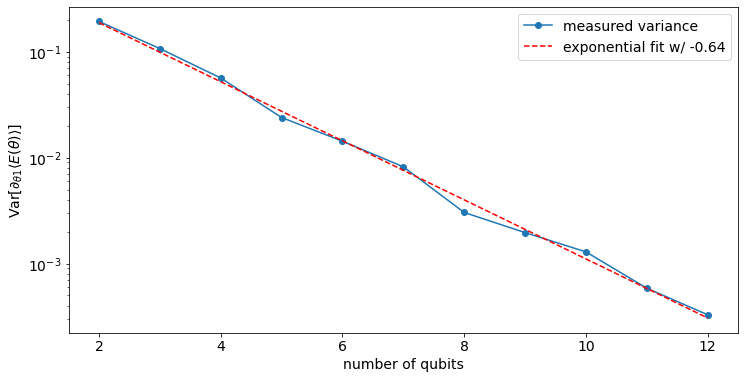

In [31]:
fit = np.polyfit(num_qubits, np.log(np.var(gradients, axis=1)), deg=1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(12, 6))
plt.semilogy(num_qubits, np.var(gradients, axis=1), 'o-', label='measured variance')
plt.semilogy(x, np.exp(fit[0] * x + fit[1]), 'r--', label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1} \langle E(\theta) \rangle]$')
plt.legend(loc='best');

Oh no! The variance decreases exponentially! This means our gradients contain less and less information and we'll have a hard time to train the model. This is known as the **barren plateau problem** or **exponentially vanishing gradients**, discussed in detail in References [4](#References) and [5](#References). 

<div class="alert alert-block alert-info">

**add ``try it yourself`` widget**

Do natural gradients have barren plateaus? Try create the above barren plateau plot for natural gradients instead of vanilla gradients in IBM Quantum Lab. You will need to write a new function _``sample_natural_gradients``_ that computes the natural gradient instead of the gradient.

</div>

Is there something we can do about these barren plateaus? It's a hot topic in current research and there are some proposals to mitigate barren plateaus.

Let's have a look at how global and local cost functions and the depth of the ansatz influences the barren plateaus. First, we look at short depth, single layer circuits with global operators. 

In [32]:
num_qubits = list(range(2, 13))
fixed_depth_global_gradients = [sample_gradients(n, 1) for n in num_qubits]  

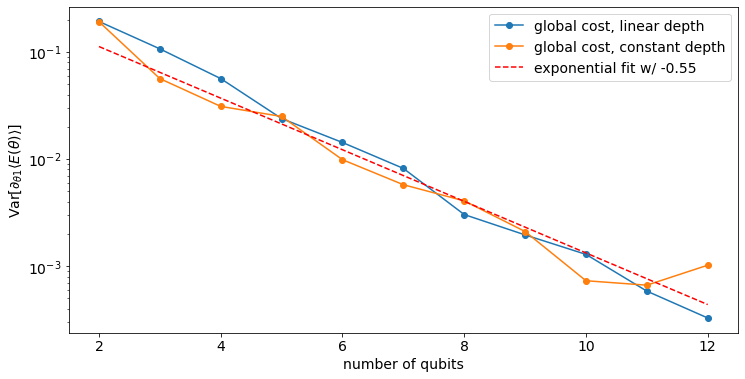

In [33]:
fit = np.polyfit(num_qubits, np.log(np.var(fixed_depth_global_gradients, axis=1)), deg=1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(12, 6))
plt.semilogy(num_qubits, np.var(gradients, axis=1), 'o-', label='global cost, linear depth')
plt.semilogy(num_qubits, np.var(fixed_depth_global_gradients, axis=1), 'o-', label='global cost, constant depth')
plt.semilogy(x, np.exp(fit[0] * x + fit[1]), 'r--', label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1} \langle E(\theta) \rangle]$')
plt.legend(loc='best');

We see that short depth, single layer circuits with global operators still give us barren plateaus. 

What if we use local operators?

In [34]:
num_qubits = list(range(2, 13))
linear_depth_local_gradients = [sample_gradients(n, n, local=True) for n in num_qubits]  

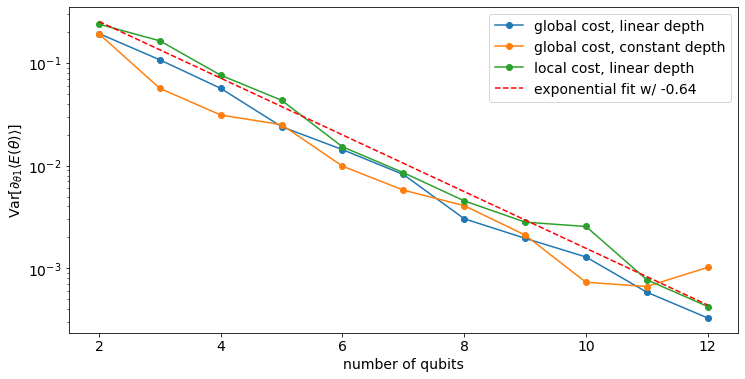

In [35]:
fit = np.polyfit(num_qubits, np.log(np.var(linear_depth_local_gradients, axis=1)), deg=1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(12, 6))
plt.semilogy(num_qubits, np.var(gradients, axis=1), 'o-', label='global cost, linear depth')
plt.semilogy(num_qubits, np.var(fixed_depth_global_gradients, axis=1), 'o-', label='global cost, constant depth')
plt.semilogy(num_qubits, np.var(linear_depth_local_gradients, axis=1), 'o-', label='local cost, linear depth')
plt.semilogy(x, np.exp(fit[0] * x + fit[1]), 'r--', label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1} \langle E(\theta) \rangle]$')
plt.legend(loc='best');

We see that circuits with local operators still give us barren plateaus. 

How about short depth, single layer, circuits with local operators?

In [36]:
num_qubits = list(range(2, 13))
fixed_depth_local_gradients = [sample_gradients(n, 1, local=True) for n in num_qubits]  

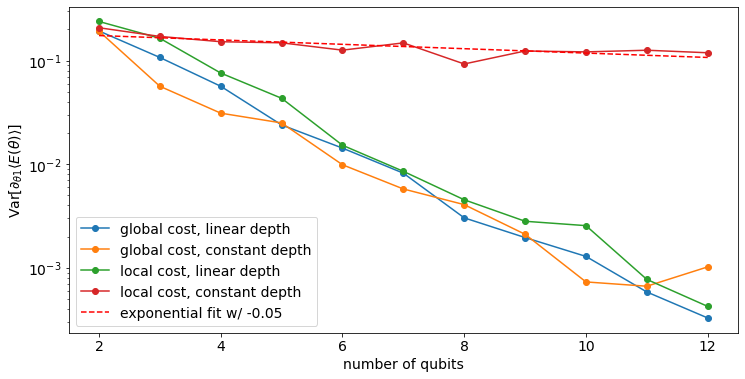

In [37]:
fit = np.polyfit(num_qubits, np.log(np.var(fixed_depth_local_gradients, axis=1)), deg=1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(12, 6))
plt.semilogy(num_qubits, np.var(gradients, axis=1), 'o-', label='global cost, linear depth')
plt.semilogy(num_qubits, np.var(fixed_depth_global_gradients, axis=1), 'o-', label='global cost, constant depth')
plt.semilogy(num_qubits, np.var(linear_depth_local_gradients, axis=1), 'o-', label='local cost, linear depth')
plt.semilogy(num_qubits, np.var(fixed_depth_local_gradients, axis=1), 'o-', label='local cost, constant depth')
plt.semilogy(x, np.exp(fit[0] * x + fit[1]), 'r--', label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1} \langle E(\theta) \rangle]$')
plt.legend(loc='best');

We see that the variance of the local operator, constant depth circuit gradients don't vanish, that is, we don't get barren plateaus. However, these circuits are usually easy to simulate and hence these models won't provide any advantage over classical models. 

<div class="alert alert-block alert-info">

**add ``quiz`` widget**

question:
- The variance of the gradient does not vanish for these types of circuits:
    
answers:
- global operator, linear depth
- global operator, constant depth
- local operator, linear depth
- local operator, constant depth (correct)
</div>

This is the inspiration for layerwise training, where we start with a basic circuit that may not provide any quantum advantage, with one layer of rotations using local operators. We optimize and fix these parameters, then in the next step, we had a second layer of rotations using local operators, and optimize and fix those, and continue for however many layers we want. This potentially avoids barren plateaus as each optimization step is only using constant depth circuits with local operators. 

<figure>
  <img src="images/layertraining.png" style="width:800px">
</figure>

We can implement this in Qiskit in the following way:

In [38]:
num_qubits = 6
operator = Z ^ Z ^ (I ^ (num_qubits - 4))

def minimize(circuit, optimizer):
    initial_point = np.random.random(circuit.num_parameters)
    
    exp = StateFn(operator, is_measurement=True) @ StateFn(circuit)
    grad = Gradient().convert(exp)
    
    exp = PauliExpectation().convert(exp)
    grad = PauliExpectation().convert(grad)

    sampler = CircuitSampler(quantum_instance, caching="all")
    
    def loss(x):
        values_dict = dict(zip(circuit.parameters, x))
        return np.real(sampler.convert(exp, values_dict).eval())
    
    def gradient(x):
        values_dict = dict(zip(circuit.parameters, x))
        return np.real(sampler.convert(grad, values_dict).eval())

    return optimizer.optimize(circuit.num_parameters, loss, gradient, initial_point=initial_point)

In [39]:
def layerwise_training(ansatz, max_num_layers, optimizer):
    optimal_parameters = []
    fopt = None
    for reps in range(1, max_num_layers):
        ansatz.reps = reps
        
        # fix the already optimized parameters
        values_dict = dict(zip(ansatz.parameters, optimal_parameters))
        
        # mark parameters that need to be optimized
        partially_bound = ansatz.bind_parameters(values_dict)
        
        xopt, fopt, _ = minimize(partially_bound, optimizer)
        print('Layer:', reps, ' Best Value:', fopt)
        optimal_parameters += list(xopt)
    
    return fopt, optimal_parameters

In [40]:
ansatz = RealAmplitudes(4, entanglement='linear')
optimizer = GradientDescent(maxiter=50)

In [41]:
np.random.seed(12)
fopt, optimal_parameters = layerwise_training(ansatz, 4, optimizer)

Layer: 1  Best Value: 0.2421875
Layer: 2  Best Value: -0.14428710937499992
Layer: 3  Best Value: -0.513427734375


We see that as we increase the circuit depth, our loss function decreases towards -1, so we don't see any barren plateaus. 

## References

1. Maria Schuld, Ville Bergholm, Christian Gogolin, Josh Izaac and Nathan Killoran, *Evaluating analytic gradients on quantum hardware*, Physical Revview A 99, 032331 (2019), [doi:10.1103/PhysRevA.99.032331](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.99.032331), [arXiv:1811.11184](https://arxiv.org/abs/1811.11184).
2. James Stokes, Josh Izaac, Nathan Killoran and Giuseppe Carleo, *Quantum Natural Gradient*, Quantum 4, 269 (2020), [doi:10.22331/q-2020-05-25-269](https://doi.org/10.22331/q-2020-05-25-269), [arXiv:1909.02108](https://arxiv.org/abs/1909.02108).
3. Julien Gacon, Christa Zoufal, Giuseppe Carleo and Stefan Woerner, *Simultaneous Perturbation Stochastic Approximation of the Quantum Fisher Information*, [arXiv:2103.09232](https://arxiv.org/abs/2103.09232).
4. Jarrod R. McClean, Sergio Boixo, Vadim N. Smelyanskiy, Ryan Babbush and Hartmut Neven, *Barren plateaus in quantum neural network training landscapes*, Nature Communications, Volume 9, 4812 (2018), [doi:10.1038/s41467-018-07090-4](https://www.nature.com/articles/s41467-018-07090-4), [arXiv:1803.11173](https://arxiv.org/abs/1803.11173).
5. M. Cerezo, Akira Sone, Tyler Volkoff, Lukasz Cincio and Patrick J. Coles, *Cost Function Dependent Barren Plateaus in Shallow Parametrized Quantum Circuits*, Nature Communications 12, 1791 (2021), [doi:10.1038/s41467-021-21728-w](https://www.nature.com/articles/s41467-021-21728-w), [arXiv:2001.00550](https://arxiv.org/abs/2001.00550).

In [42]:
import qiskit.tools.jupyter
%qiskit_version_table